
    precompute=True
    Use lr_find() to find highest learning rate where loss is still clearly improving
    Train last layer from precomputed activations for 1-2 epochs
    Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
    Unfreeze all layers
    Set earlier layers to 3x-10x lower learning rate than next higher layer
    Use lr_find() again
    Train full network with cycle_mult=2 until over-fitting



# Notebook setup and imports

## Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

## Notebook setup

In [3]:
# Check for GPU
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)

True
True


# Data

## Obtain data

The data for this notebook can be obtained from Kaggle with the following [Kaggle API](https://github.com/Kaggle/kaggle-api) call:

```bash
kaggle competitions download -c dog-breed-identification
```

## Examine data

In [4]:
PATH = "../../data/dogbreeds/"

In [5]:
!ls {PATH}

del.txt		sample_submission.csv	   test      train
labels.csv	sample_submission.csv.zip  test.zip  train.zip
labels.csv.zip	subm			   tmp


In [6]:
!ls {PATH + '/train'} -U | head -5

db19763a49f08e0e887b874be8c88e99.jpg
2ac10837ecb82f466b9a9f60bacfe99f.jpg
e4a2121c2de5de095855677d4e6eca71.jpg
be1eb6914aded0282c88d6218ca94769.jpg
9c6e6453cf7792a3d8b9ebb78f543b31.jpg
ls: write error: Broken pipe


In [7]:
print("Number of training images:")
%ls -1 {PATH + '/train'} | wc -l

print("Number of test images:")
%ls -1 {PATH + '/test'} | wc -l

Number of training images:
10222
Number of test images:
10357


In [8]:
labels = pd.read_csv(PATH + '/labels.csv')
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [9]:
print("Number of classes:", labels['breed'].nunique())

Number of classes: 120


In [10]:
print('Number of observations per class:')
labels.groupby('breed').agg('count')

Number of observations per class:


,id
breed,
affenpinscher,80
afghan_hound,116
african_hunting_dog,86
airedale,107
american_staffordshire_terrier,74
appenzeller,78
australian_terrier,102
basenji,110
basset,82


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5c7a291048>]], dtype=object)

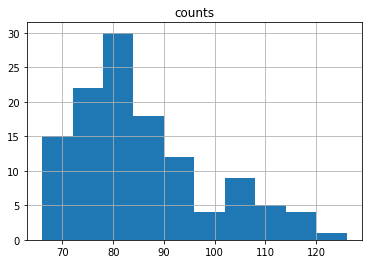

In [11]:
labels.groupby(['breed']).size().reset_index(name='counts').sort_values('counts', ascending=False).hist()

In [12]:
trainImgs = [i+'.jpg' for i in labels['id']]
trainDims = {k: PIL.Image.open(PATH + '/train/' + k).size for k in trainImgs}

In [13]:
rowSizes, colSizes = list(zip(*trainDims.values()))
rowSizes = np.array(rowSizes)
colSizes = np.array(colSizes)

(array([3798., 6259.,  108.,   18.,   11.,    4.,   19.,    2.,    1.,    2.]),
 array([  97. ,  413.7,  730.4, 1047.1, 1363.8, 1680.5, 1997.2, 2313.9, 2630.6, 2947.3, 3264. ]),
 <a list of 10 Patch objects>)

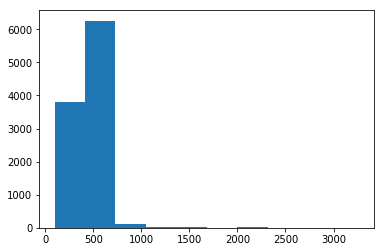

In [14]:
plt.hist(rowSizes)

(array([3595., 6395.,  150.,   28.,   18.,   20.,   10.,    3.,    0.,    3.]),
 array([ 102.,  348.,  594.,  840., 1086., 1332., 1578., 1824., 2070., 2316., 2562.]),
 <a list of 10 Patch objects>)

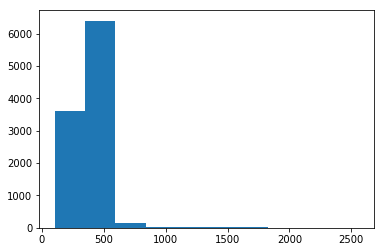

In [15]:
plt.hist(colSizes)

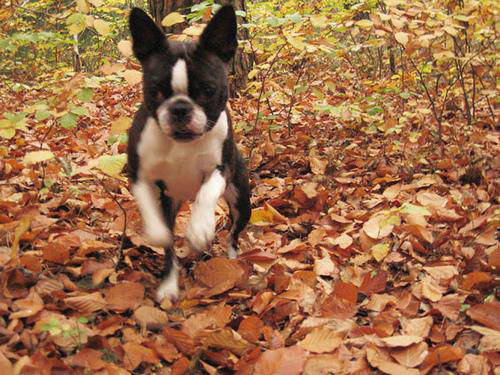

In [16]:
img = PIL.Image.open(PATH + '/train/' + trainImgs[0])
img

## Prepare data

In [17]:
# Set the size we want the images resized to
# Most of ImageNet models are trained on either 224 by 224 or 299 by 299 images
imgSize = 224

# Algorithm architecture - We can utilize a deeper arch later on; this one allows us to initial train quick
arch = resnet34

# Batch size
batchSize = 32

# Validation indices
# Library sets random 20% of the data for validation set
# Also, minus one to ignore the header row
valIndices = get_cv_idxs(len(list(open(f'{PATH}labels.csv')))-1) 

# Model

Overall process:
* Set precompute=True, so we don't utilize the augmented images
* Use lr_find() to find highest learning rate where loss is still clearly improving
* Train last layer from precomputed activations for 1-2 epochs
* Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
* Unfreeze all layers
* Set earlier layers to 3x-10x lower learning rate than next higher layer
* Use lr_find() again
* Train full network with cycle_mult=2 until over-fitting

## Helper functions

---
First, we'll crib a fastAI function to allow us to control the sizes of the images we work with

* http://forums.fast.ai/t/how-to-train-on-the-full-dataset-using-imageclassifierdata-from-csv/7761/13
* http://forums.fast.ai/t/how-to-train-on-the-full-dataset-using-imageclassifierdata-from-csv/7761/37

In [18]:
def get_data(imgSize, batchSize): # sz: image size, bs: batch size
    
    print('imgSize: ', imgSize)
    print('batchSize: ', batchSize)
    
    # Image augmentation/transformation object
    tfms = tfms_from_model(arch, imgSize, aug_tfms=transforms_side_on, max_zoom=1.1)

    # Collect the images into a fastAI data object
    data = ImageClassifierData.from_csv(
        PATH, 
        'train', 
        f'{PATH}labels.csv', 
        test_name='test',
        val_idxs=valIndices, 
        suffix='.jpg', 
        tfms=tfms, 
        bs=batchSize
    )
    
    # Reading the jpgs and resizing is slow for big images, so resizing them all to a smaller size first saves time
    return data if imgSize > 300 else data.resize(imgSize, 'tmp') 


## Create data collection,

In [19]:
data = get_data(imgSize, batchSize)

imgSize:  224
batchSize:  32


## Create algorithm

We set `precompute=True`, so we don't utilize the augmented images.

In [20]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 64/64 [00:11<00:00,  6.20it/s]


## Find best learning rate

Use lr_find() to find highest learning rate where loss is still clearly improving

In [21]:
learn.lr_find()

 69%|██████▉   | 176/256 [00:01<00:02, 34.71it/s, loss=3.47]


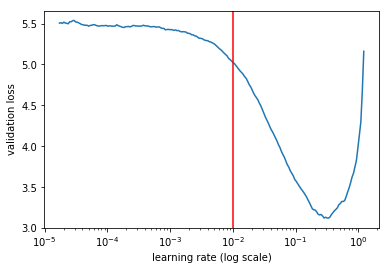

In [22]:
learn.sched.plot()
plt.axvline(x=1e-2, color="r")

In [23]:
lr = 1e-2

## Train last layer

Train last layer from precomputed activations for 1-2 epochs:

In [24]:
learn.fit(lr, 2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.376854   0.770858   0.78816   
    1      0.841844   0.625042   0.811644                    



[array([0.62504]), 0.8116438357330815]

In [25]:
learn.save("last_layer_224")

## Train last layer w/ data augmentation

Tain last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1

In general, good starting points are:

    n_cycle=3, cycle_len=1, cycle_mult=2
    n_cycle=3, cycle_len=2 (no cycle_mult)
    
The `cycle_mult` param helps to prevent under fitting.  When you are under fitting, it means `cycle_len=1` is too short (learning rate is getting reset before it had the chance to zoom in properly). So we add `cycle_mult=2` (i.e. 1st cycle is 1 epoch, 2nd cycle is 2 epochs, and 3rd cycle is 4 epochs).  In effect we are "popping" out of spikey areas of the solution set, and this will alow us to avoid getting stuck in local minima.

In [26]:
learn.precompute=False
%time learn.fit(lr, 3, cycle_len = 1, cycle_mult = 2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.810203   0.584417   0.816047  
    1      0.729288   0.571278   0.810665                    
    2      0.684438   0.545616   0.818982                    
    3      0.67592    0.54093    0.823875                    
    4      0.630541   0.539792   0.817515                    
    5      0.588133   0.529386   0.822896                    
    6      0.545588   0.530457   0.816536                    

CPU times: user 13min 1s, sys: 6min 48s, total: 19min 49s
Wall time: 6min 57s


[array([0.53046]), 0.816536203639148]

In [27]:
learn.save("last_layer_aug_224")

---
Pass this point the algorithm seems to get stuck, so we are going to try switching image sizes.

Starting training on small images for a few epochs, then switching to bigger images, and continuing training is an amazingly effective way to avoid overfitting.

Also, *facepalm*:  `Unfreezing (in this case, training convolutional layers did not help in the slightest since the images actually came from ImageNet).`  This very likely explains why the algorithm was stuck...  :(

In [28]:
#del learn
#learn = ConvLearner.pretrained(arch, data, precompute=False)
#learn.load("last_layer_aug_224")

In [29]:
learn.set_data(get_data(299, batchSize))

imgSize:  299
batchSize:  32


In [30]:
lr = 1e-2
%time learn.fit(lr, 3, cycle_len = 1, cycle_mult = 2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.579094   0.4458     0.862035  
    1      0.564925   0.44671    0.862524                    
    2      0.521183   0.434103   0.858611                    
    3      0.553557   0.455294   0.846869                    
    4      0.482797   0.434056   0.860568                    
    5      0.460326   0.427954   0.8591                      
    6      0.443944   0.427492   0.866928                    

CPU times: user 24min 13s, sys: 11min 56s, total: 36min 9s
Wall time: 15min 8s


[array([0.42749]), 0.8669275930716334]

In [31]:
learn.save("last_layer_aug_299")

## Unfreeze all layers

(See notes above on why this isn't going to work well with this data set.)

## Train with variable learning rates

Set earlier layers to 3x-10x lower learning rate than next higher layer

(See notes above on why this isn't going to work well with this data set.)

In [32]:
#lr=np.array([1e-5,1e-4,1e-2])
#%time learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [33]:
#learn.save("all_layers_224")
#learn.load("all_layers_224")

# Find best learning rate

Use lr_find() again:

In [34]:
#learn.load("last_layer_aug_299")

In [35]:
learn.lr_find()

 79%|███████▉  | 202/256 [01:25<00:24,  2.21it/s, loss=1.59] 

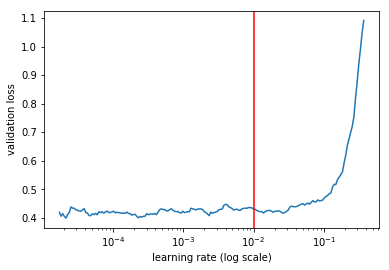

In [36]:
learn.sched.plot()
plt.axvline(x=0.01, color="r")

In [37]:
lr = 0.01

## Train full network

Train full network with cycle_mult=2 until over-fitting:

In [38]:
learn.fit(lr, 1, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.472087   0.431133   0.858121  


[array([0.43113]), 0.8581213306074273]

In [39]:
learn.save("final_224")
learn.fit(lr, 1, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.446379   0.430478   0.863014  


[array([0.43048]), 0.8630136987467801]

In [40]:
learn.save("final_224")
learn.fit(lr, 1, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.435652   0.433143   0.863014  


[array([0.43314]), 0.8630136987467801]

# Predictions

In [41]:
#learn.load("final_224")

## Test Time Augmentation

In [42]:
# The next statement is applied to the VAL data set
log_preds, y = learn.TTA()

## Examine prediction results

In [43]:
# Record probabilities
probs = np.mean(np.exp(log_preds),0)

# Print the accuracy and loss values
print("Accuracy and loss values:")
accuracy_np(probs, y), metrics.log_loss(y, probs)

Accuracy and loss values:


(0.8737769080234834, 0.4116740976322924)

In [44]:
# Get the predictions from the class probs
preds = np.argmax(probs, axis=1)

# Examine the first 10 predictions
print("First 10 predictions:")
preds[:10]

First 10 predictions:


array([19, 15, 19, 99, 73, 79, 21, 38, 10, 26])

In [45]:
# Write some helper functions to show images along w/ true and predicted classifications
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=12)
        plt.imshow(ims[i])

def plot_val_with_title(idxs, title):
    
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    
    pred_classes = [data.classes[preds[x]] for x in idxs]
    true_classes = [data.classes[data.val_y[x]] for x in idxs]
    
    title_classes = ['[Y]: ' + true_classes[i] + '\n' + '[y]: ' + pred_classes[i] for i in range(len(true_classes))]
    
    print(title)
    return plots(imgs, rows=2, titles=title_classes, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')

---
View correct results

Correct classifications - First 8


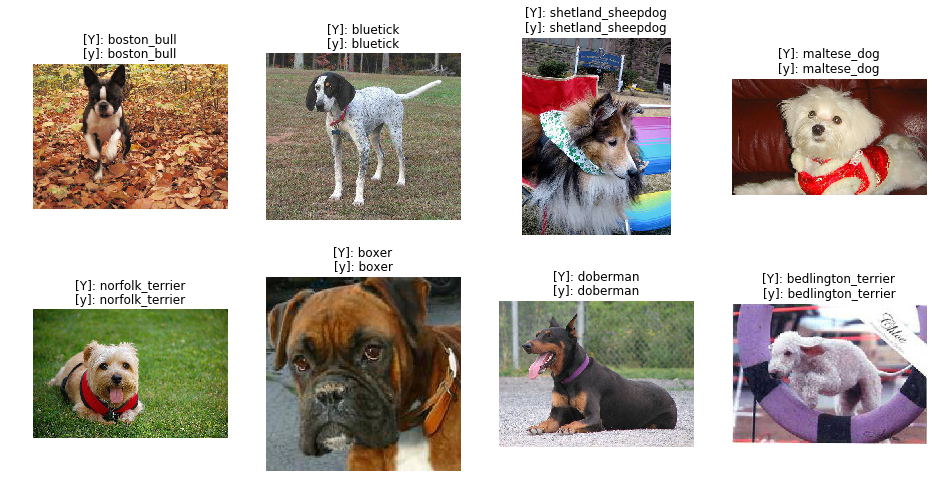

In [46]:
plot_val_with_title(np.where(data.val_y == preds)[0][:8], "Correct classifications - First 8")

---
View incorrect results

Incorrect classifications - First 8


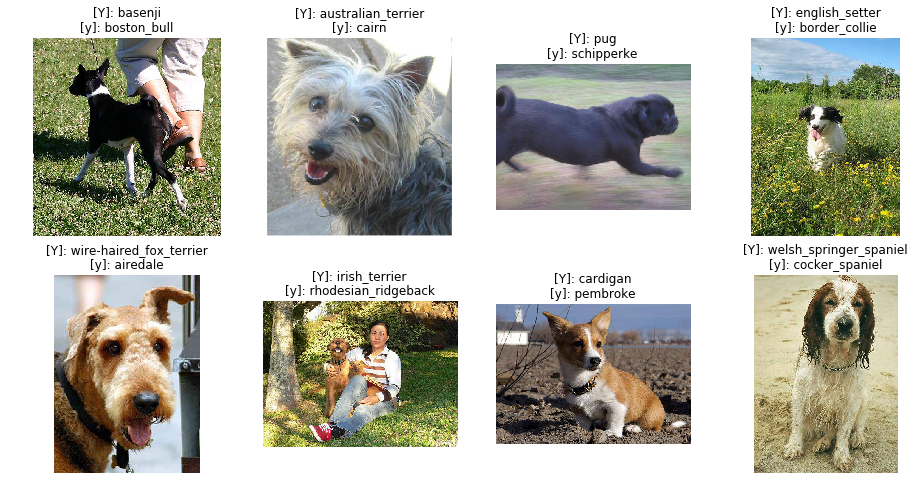

In [47]:
plot_val_with_title(np.where(data.val_y != preds)[0][:8], "Incorrect classifications - First 8")

# Create Kaggle submission

In [48]:
# We want to use the test dataset rather than validation dataset,
# so set 'is_test=True'
log_preds, y = learn.TTA(is_test=True) 

In [49]:
# Record the probabilities
probs = np.mean(np.exp(log_preds),0)

In [50]:
# Sanity check
probs.shape 

(10357, 120)

In [51]:
# Create Pandas dataframe to hold submission results
df = pd.DataFrame(probs)

# One column for each class (i.e. 120)
df.columns = data.classes

In [52]:
# Strip off the folder name and file extension from the image file names and add to dataframe
df.insert(0, 'id', [o[5:-4] for o in data.test_ds.fnames])

In [53]:
# Examine some results
df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,06c65731c3bb87dfadb14cbc4e7504c7,2.706722e-07,2.665570e-09,1.096767e-07,8.097065e-09,2.074843e-05,3.025456e-06,8.741658e-06,9.962026e-01,1.713660e-06,...,7.165549e-07,1.616363e-03,1.029207e-06,4.923180e-06,3.362051e-09,7.306659e-08,1.044250e-06,8.569087e-07,3.264806e-06,9.192993e-07
1,d44abfeefa52a5ca9c5d74d3f427f2ce,3.108862e-04,2.030765e-04,8.312975e-06,3.211521e-03,5.605461e-05,1.506748e-05,8.149455e-05,1.527092e-04,1.031357e-04,...,7.154547e-01,8.216709e-05,2.254859e-04,1.711643e-05,2.801578e-05,2.228911e-05,2.595907e-05,7.808027e-06,1.672416e-03,2.110080e-04
2,60e2c06786e02e74c2822ac7266478d2,1.934155e-08,7.902429e-10,5.436859e-08,2.498085e-08,3.806211e-06,7.438385e-07,6.032112e-06,9.939815e-01,1.251655e-07,...,3.671789e-07,2.373515e-03,1.419487e-06,1.219988e-06,1.638618e-09,3.182534e-08,6.951374e-07,9.945255e-07,2.977285e-06,4.353311e-07
3,20d14fb3517af117763a501e72335276,7.058019e-10,9.483470e-06,2.587043e-11,2.246163e-09,1.304853e-10,5.583186e-11,1.216598e-09,1.814305e-11,3.564363e-10,...,3.900584e-11,1.157497e-11,1.042105e-11,5.247413e-11,5.406106e-11,2.242577e-10,2.977688e-12,5.439555e-11,1.493594e-11,1.502282e-10
4,dce52d7235885d9ad2ae34006e2ecb1e,2.108895e-03,5.555168e-04,5.864449e-04,2.966040e-04,3.620864e-05,4.997769e-04,1.436873e-05,1.318215e-05,9.431989e-04,...,3.844498e-05,2.295821e-06,1.098720e-04,2.465298e-05,6.212107e-04,1.431158e-04,1.134414e-04,3.536240e-04,2.032102e-05,9.509629e-05


In [54]:
# Write submission file to disk
SUBM = f'{PATH}/subm/'
os.makedirs(SUBM, exist_ok=True)
df.to_csv(f'{SUBM}subm.gz', compression='gzip', index=False)

In [55]:
# Provide link to download submission file
FileLink(f'{SUBM}subm.gz')

/home/ubuntu/fastai/data/dogbreeds/subm/subm.gz

Kaggle score:  0.41982